In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [2]:
df_orig = pd.read_csv("data-from-fig-2.csv", index_col=0)
# drop the last data points when substrate is running out
df = df_orig.loc[:7].copy()
# rename columns for convenience
df.columns = ["x", "p", "s"]
# we don't need the glucose concentration
df = df[["x", "p"]]
# convert the ethanol mM to g/L
df["p"] = df["p"] / 1000 * 46

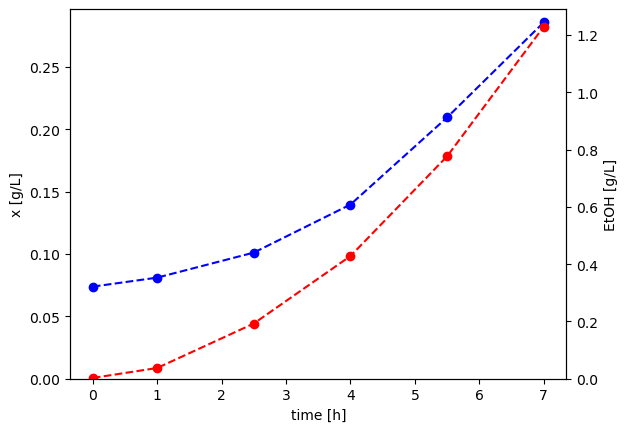

In [3]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(df["x"], "bo--", label="x")
ax2.plot(df["p"], "ro--", label="EtOH")

ax.set_xlabel("time [h]")
ax.set_ylabel("x [g/L]")
ax2.set_ylabel("EtOH [g/L]")

for ax in fig.axes:
    ax.set_ylim(0, ax.get_ylim()[1])

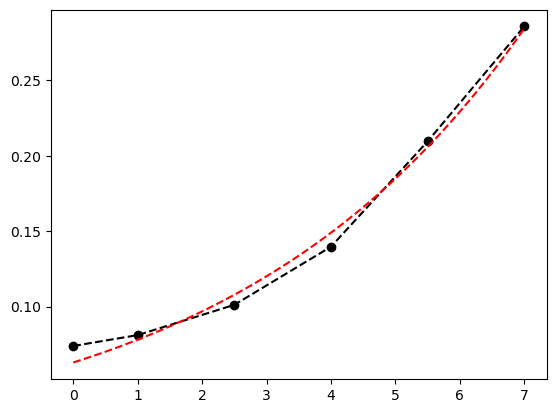

In [4]:
# try to fit exponential growth to the data
t = df.index.values
t_interp = np.linspace(df.index[0], df.index[-1], 101)


def fit_x_exp(t, x0, mu):
    return x0 * np.exp(mu * t)


(x0_fit, mu_fit), _ = scipy.optimize.curve_fit(
    fit_x_exp,
    t,
    df["x"],
    p0=[0.3, 0.1],
)

x_fit = fit_x_exp(t_interp, x0_fit, mu_fit)

plt.plot(t, df["x"], "ko--")
plt.plot(t_interp, x_fit, "r--")

Due to the lag phase in the first few hours the fit is not great. However, we can instead also just interpolate the biomass concentrations with cubic splines and use those for fitting the ODE for ethanol formation later.

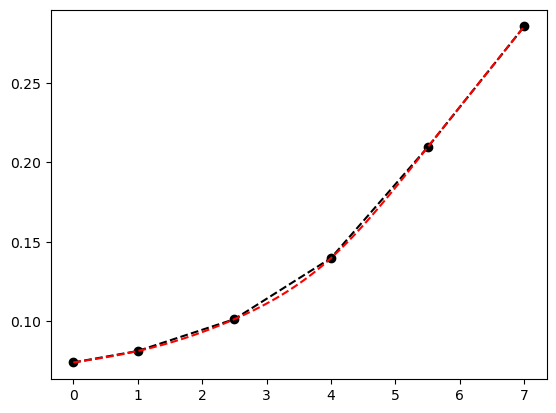

In [5]:
# interpolate growth with cubic splines
x_cs = scipy.interpolate.CubicSpline(df.index, df["x"], bc_type="natural")
# let's also get the first derivative of the spline (we can use this later to calculate
# mu at any point in time)
x_cs_d1 = x_cs.derivative(1)

# let's visualize the interpolation
x_interp = x_cs(t_interp)

plt.plot(df.index, df["x"], "ko--")
plt.plot(t_interp, x_interp, "r--")

Now that we got ways to interpolate $x$ and $\mu$, use them to integrate the ODE for $p$ in order to fit $pi_0$ and $pi_1$ (according to $\frac{dp}{dt} = x (\pi_0 + \mu \pi_1)$)

In [6]:
def predict_p(t, pi_0, pi_1, p0=0):
    # define an ODE for the ethanol concentration
    def ODE(t, p):
        x = x_cs(t)
        mu = x_cs_d1(t) / x
        return x * (pi_0 + mu * pi_1)

    # solve the ODE
    res = scipy.integrate.solve_ivp(
        fun=ODE,
        t_span=(t[0], t[-1]),
        y0=[p0],
        t_eval=t,
    )
    return pd.Series(res.y[0], index=res.t, name="EtOH [g/L]")


def get_residuals(params):
    pi_0, pi_1 = params
    p_pred = predict_p(t, pi_0, pi_1)
    return df.loc[t, "p"] - p_pred


res = scipy.optimize.least_squares(
    get_residuals,
    x0=[0.1, 0.1],
    bounds=([0, 0], [np.inf, np.inf]),
)

pi_0, pi_1 = res.x
print(f"stage 1: {pi_0=:.3g}, {pi_1=:.3g}")

stage 1: pi_0=0.454, pi_1=3.62


Let's plot the predicted ethanol concentrations with these parameters and the interpolated biomass concentrations.

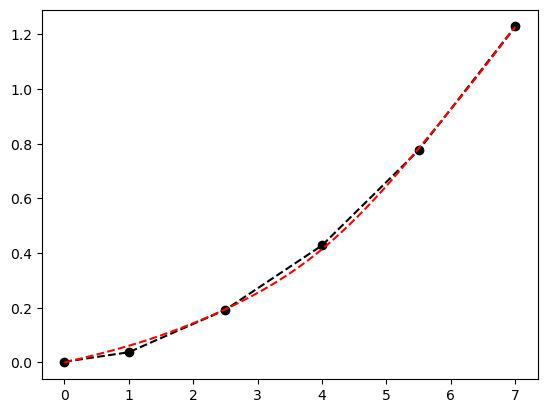

In [7]:
# check the fit of product concentration visually
plt.plot(df.index, df["p"], "ko--")
plt.plot(t_interp, predict_p(t_interp, *res.x), "r--")

This doesn't look too bad! We can also check if this gives us a similar value to the $r_{Eth}= 28.77$ mmol/(g CDW h) reported in Table 2 for the exponential phase between 2.5 and 7 hours (at a $\mu$ of 0.235 /h).

In [8]:
r_Eth_table = 28.8 / 1000 * 46
r_Eth_ours = pi_0 + 0.235 * pi_1
print(f"{r_Eth_table=:.3f}, {r_Eth_ours=:.3f}")

r_Eth_table=1.325, r_Eth_ours=1.305


Table 3 lists the specific rate of ethanol formation under nitrogen starvation (which would be stage 2 in our two stage process). Since $\mu=0$ (as can be seen in Fig. 3), we can say $\pi = \pi_0 + \mu \pi_1 = \pi_0 = r_{Eth} = 5.71$ mmol/(g CDW h). 

In [9]:
print(f"stage 1: pi_0 = {5.71 / 1000 * 46:.3g} g/L")

stage 1: pi_0 = 0.263 g/L
